In [1]:
import os
import glob
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme(style="whitegrid")
import pybedtools as pbt
import numpy as np
from scipy.stats import mannwhitneyu
from collections import namedtuple

pd.options.display.max_rows = 200

os.chdir('<project-dir>')

outdir = 'results/hg38/finemapping/sgls_summary/'
os.makedirs(outdir, exist_ok=True)

In [2]:
pbt.set_bedtools_path('<path-to-bedtools-bin>/')

#### Adding gene information

In [3]:
old_fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.w_genetypes.bed'
fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.genes_only.bed.gz'
gencode_df = pd.read_table(fn, header=None)
gencode_df = gencode_df.iloc[:, [0,1,2,5,6,7,8]]
gencode_df.columns =['chrom', 'start', 'end', 'strand', 'genename', 'geneid', 'genetype']
# gencode_df = gencode_df.loc[gencode_df.type == 'gene'].drop('type', axis=1)
gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/mnt/BioHome/jreyna/tmp/ipykernel_3811861/3830488000.py:7: SyntaxWarning: invalid escape sequence '\.'
  gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)


## Load all SGL Data


In [4]:
#fns = glob.glob('results/hg38/finemapping/sgls/*/Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1.5000.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/*All-Donors*.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/*.finemap_sgls.tsv')
all_data = []
for fn in fns:
    
    # split meta information
    info = fn.split('/')
    genome = info[1]
    causaldb_fn = info[4]
    sample = info[5].rsplit('.', maxsplit=3)[0]

    # load sgl table
    tdf = pd.read_table(fn)
    tdf.loc[:, 'causaldb_fn'] = causaldb_fn
    tdf.loc[:, 'sample'] = sample

    # append to all
    all_data.append(tdf)

all_df = pd.concat(all_data)

In [5]:
# load meta information
causal_metadata_fn = 'workflow/scripts/finemap_sgls/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'
causal_metadata = pd.read_table(causal_metadata_fn, header=None)

# merge meta data
causal_metadata_mapper =  causal_metadata.iloc[:, [2, 8, 18]]
causal_metadata_mapper.columns = ['mesh_term', 'author', 'filename']
all_df = all_df.merge(causal_metadata_mapper, left_on='causaldb_fn', right_on='filename')

# add snp position
all_df['snp_pos'] = all_df['chrom'].astype(str) + ':' + all_df['end_snp'].astype(str)

FileNotFoundError: [Errno 2] No such file or directory: 'workflow/scripts/finemap_sgls/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'

#### Mini-summary

In [ ]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
t.shape

(23846, 37)

In [ ]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'filename'])
t.shape

(28976, 37)

In [ ]:
# count the samples
num_samples = all_df['sample'].nunique()
print('Number of samples with SGLs:', num_samples)

# count the total number of sgl events across all studies
print('Number of SGL events:', all_df.shape[0]) 

# count the unique snps
num_uniq_snps = (all_df['chrA_loop'].astype(str) + '-' + all_df['end_snp'].astype(str)).nunique()
print('Number of unique snps:', num_uniq_snps)

# count the unique genes
num_uniq_genes = all_df.geneid.nunique()
print('Number of unique genes:', num_uniq_genes)

# count the unique loops
uniq_loops_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop'])
print('Number of unique loops:', uniq_loops_df.shape[0])

# count the total number of sgls
uniq_sgls_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid'])
print('Number of unique sgls:', uniq_sgls_df.shape[0])

Number of samples with SGLs: 6
Number of SGL events: 60474
Number of unique snps: 3564
Number of unique genes: 2052
Number of unique loops: 6053
Number of unique sgls: 23505


Also want to look at the number of SNPs we started with

In [ ]:
num_snps_study = pd.read_table('results/hg38/finemapping/snps/singles/num_snps.tsv', header=None)
num_snps_study.columns = ['num_snps', 'filename']
num_snps_study = num_snps_study.merge(causal_metadata_mapper)
num_snps_study_mesh = num_snps_study.groupby('mesh_term').sum()
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


## Overview of SGLs Across Each Disease

### Count the number of sgls per GWAS Study

I would expect that, in general, that studies with more snps will have more SGLs.

In [ ]:
grps = all_df.groupby(['causaldb_fn', 'mesh_term', 'author'])
counts = grps['chrA_loop'].count().to_frame()
counts.columns = ['num_sgls']

In [ ]:
counts.sort_values(['mesh_term', 'num_sgls'], ascending=[True, False])

,,,num_sgls
causaldb_fn,mesh_term,author,
PH378,"Arthritis, Rheumatoid",Okada Y,6612
AT452,"Arthritis, Rheumatoid",Roslin Institute,2288
CA104,"Arthritis, Rheumatoid",Eyre S,1674
AT551,"Arthritis, Rheumatoid",Roslin Institute,1672
CA391,"Arthritis, Rheumatoid",Stahl EA,504
AT454,"Arthritis, Rheumatoid",Roslin Institute,224
BE151,"Arthritis, Rheumatoid",Nealelab,217
GD09159,"Dermatitis, Atopic",Sliz E,5031
GD08996,"Diabetes Mellitus, Type 1",Chiou J,10970


In [ ]:
counts.describe()

,num_sgls
count,18.000000
mean,3359.666667
std,3252.206599
min,217.000000
25%,1175.500000
50%,2348.000000
75%,4153.500000
max,10970.000000


### Count and plot the number of sgls, snps and genes per mesh term

In [ ]:
uniq_sgls_mesh_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startA_loop'].astype(str) + '--' \
                            + uniq_sgls_mesh_df['chrB_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startB_loop'].astype(str)

mesh_sgl_grps = uniq_sgls_mesh_df.groupby(['mesh_term'])
sgl_counts = mesh_sgl_grps['loop_id'].count().to_frame()
sgl_counts.columns = ['num_sgls']
sgl_counts.sort_values('num_sgls', ascending=False)

/mnt/BioHome/jreyna/tmp/ipykernel_2757699/4268753814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \


,num_sgls
mesh_term,
"Diabetes Mellitus, Type 1",13197
"Arthritis, Rheumatoid",5484
"Dermatitis, Atopic",2796
Psoriasis,2369


In [ ]:
# number of unique genes per mesh term
mesh_gene_grps = uniq_sgls_mesh_df.drop_duplicates(['geneid', 'mesh_term']).groupby(['mesh_term'])
gene_counts = mesh_gene_grps['loop_id'].count().to_frame()
gene_counts.columns = ['num_genes']
gene_counts.sort_values('num_genes', ascending=False)

,num_genes
mesh_term,
"Diabetes Mellitus, Type 1",1322
Psoriasis,633
"Arthritis, Rheumatoid",524
"Dermatitis, Atopic",369


In [ ]:
# number of unique snps per mesh term
mesh_snp_grps = uniq_sgls_mesh_df.drop_duplicates(['snp_pos', 'mesh_term']).groupby(['mesh_term'])
snp_counts = mesh_snp_grps['loop_id'].count().to_frame()
snp_counts.columns = ['num_snps']
snp_counts.sort_values('num_snps', ascending=False)

,num_snps
mesh_term,
"Diabetes Mellitus, Type 1",2345
"Arthritis, Rheumatoid",523
"Dermatitis, Atopic",472
Psoriasis,280


In [ ]:
combine_uniq_mesh_counts = pd.concat([num_snps_study_mesh[['num_snps']], snp_counts, sgl_counts, gene_counts], axis=1)
combine_uniq_mesh_counts.columns = ['num_total_snps', 'num_snps', 'num_sgls', 'num_genes']
combine_uniq_mesh_counts

,num_total_snps,num_snps,num_sgls,num_genes
mesh_term,,,,
"Arthritis, Rheumatoid",1121,523,5484,524
"Dermatitis, Atopic",674,472,2796,369
"Diabetes Mellitus, Type 1",7729,2345,13197,1322
Psoriasis,590,280,2369,633


In [ ]:
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


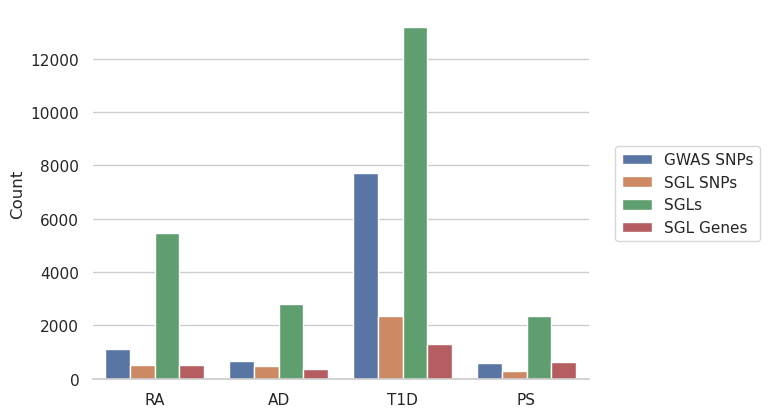

In [ ]:
# extract data
plot_data = combine_uniq_mesh_counts.melt(ignore_index=False).reset_index()
plot_data.replace({'num_total_snps': 'GWAS SNPs', 'num_snps': 'SGL SNPs',
                    'num_genes': 'SGL Genes', 'num_sgls': 'SGLs',
                    'Arthritis, Rheumatoid': 'RA', 'Dermatitis, Atopic': 'AD',
                    'Diabetes Mellitus, Type 1': 'T1D', 'Psoriasis': 'PS'}, inplace=True)

# plot data
fig, ax = plt.subplots()

sns.barplot(plot_data, x='mesh_term', y='value', hue='variable', ax=ax)

# remove left spine
sns.despine(left=True)

# move legend
sns.move_legend(ax, "upper center", bbox_to_anchor=(1.2, 0.65))

# rotate X-Axis Ticks by 45-degrees
#ax.tick_params(axis='x', labelrotation = 75)

# set labels
ax.set_xlabel('')
ax.set_ylabel('Count')
legend = ax.legend_
legend.set_title('') 

outfn = os.path.join(outdir, 'sgl_breakdowns.mega-merged-only.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

We can see that Type 1 Diabetes has the most number of SGLs. 

In [ ]:
mesh_grps = all_df.groupby(['mesh_term'])

In [ ]:
def get_top_counts(df, n=10):
    sorted_df = df.genename.value_counts().iloc[0:n]
    return(sorted_df)
mesh_grps.apply(get_top_counts)

mesh_term                  genename  
Arthritis, Rheumatoid      ARID5B        264
                           AL353759.1    241
                           HIST1H2BE     241
                           HIST1H2AK     198
                           HIST1H2BN     198
                           HIST1H3A      148
                           HIST1H4A      148
                           HIST1H2BF     145
                           HIST1H3D      145
                           AL031777.3    145
Dermatitis, Atopic         TRIB1         118
                           AL662844.4    106
                           HCG27         106
                           RNF41         103
                           NABP2         103
                           NFKBIA         98
                           AC034102.7     90
                           ZC3H10         90
                           ESYT1          90
                           RPL41          90
Diabetes Mellitus, Type 1  KANSL1-AS1    581
                 

In [ ]:
cols = ['chrA_loop', 'startA_loop', 'endA_loop',
         'chrB_loop', 'startB_loop', 'endB_loop',
         '-log10_qval_loop', 'sample', 'chr_snp'
         'end_snp', 'snp_anchor', 
         'genename', 'geneid', 
         'mesh_term', 'author', 'causaldb_fn']

new_cols = ['ChrA', 'StartA', 'EndA',
             'ChrB', 'StartB', 'EndB',
             '-log10(Q values)', 'Sample Name', 'SNP Pos'
             'SNP BP', 'SNP Anchor', 
             'Gene Name', 'Gene ID', 
             'Mesh Term', 'Author', 'CAUSALdb Study ID']

mesh_outfn = os.path.join(outdir, 'sgls.supplemental_table.mega-merged-only.xlsx')
with pd.ExcelWriter(mesh_outfn) as fw:
    for grp, grp_df in mesh_grps:
        tdf = grp_df.sort_values(['author', 'sample', 'chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'end_snp', 'geneid'])
        tdf.loc[:, 'chrA_loop'] = 'chr' + tdf.loc[:, 'chrA_loop'].astype(str)
        tdf.loc[:, 'chrB_loop'] = 'chr' + tdf.loc[:, 'chrB_loop'].astype(str)
        #tdf.columns = new_cols
        tdf.to_excel(fw, sheet_name=grp[0], index=False)

## Diving into SGLs for T1D

In [ ]:
t1d_df = mesh_grps.get_group('Diabetes Mellitus, Type 1')

In [ ]:
t1d_df.geneid.nunique()

1322

In [ ]:
t1d_df

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval,chrom,start_snp,end_snp,...,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos
0,1,112615000,112620000,1,113760000,113765000,10.508674,1,113761185,113761186,...,112619804,112619805,CAPZA1,ENSG00000116489,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186
1,1,113760000,113765000,1,113810000,113815000,7.828671,1,113761185,113761186,...,113812378,113812379,AL137856.1,ENSG00000231128,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186
2,1,113760000,113765000,1,113810000,113815000,7.828671,1,113761185,113761186,...,113812475,113812476,RSBN1,ENSG00000081019,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186
3,1,113760000,113765000,1,113925000,113930000,7.407903,1,113761185,113761186,...,113929323,113929324,HIPK1,ENSG00000163349,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186
4,1,113760000,113765000,1,113925000,113930000,7.407903,1,113761185,113761186,...,113929491,113929492,HIPK1-AS1,ENSG00000235527,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60469,9,3525000,3530000,9,4290000,4295000,19.231878,9,4293149,4293150,...,3526722,3526723,RFX3-AS1,ENSG00000232104,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,9:4293150
60470,9,3525000,3530000,9,4295000,4300000,18.131158,9,4295582,4295583,...,3526003,3526004,RFX3,ENSG00000080298,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,9:4295583
60471,9,3525000,3530000,9,4295000,4300000,18.131158,9,4295582,4295583,...,3526722,3526723,RFX3-AS1,ENSG00000232104,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,9:4295583
60472,9,3525000,3530000,9,4295000,4300000,18.131158,9,4296429,4296430,...,3526003,3526004,RFX3,ENSG00000080298,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,9:4296430


In [ ]:
# sgl_viz_cols = ['chr_snp', 'end_snp',
#                 'genename', 'geneid', 'start_gene', 'end_gene',
#                 'startA_loop', 'startB_loop', '-log10_qval',
#                 'sample', 'author']
# t1d_df.sort_values(['-log10_qval', 'chr_snp', 'end_snp'], ascending=[False, True, True])[sgl_viz_cols].head(10)

In [ ]:
t1d_uniq_sgls = t1d_df.drop_duplicates(['chrA_loop', 'chrB_loop', 'startA_loop', 'startB_loop', 'geneid', 'start_snp'])

### Count and plot the number of sgls and snps per gene

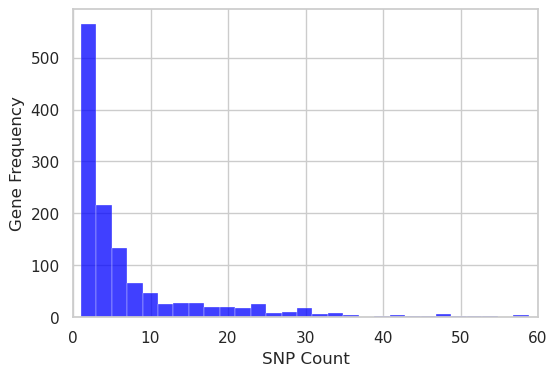

In [ ]:
# getting the data
snps_per_gene = t1d_uniq_sgls.groupby('geneid').snp_pos.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.histplot(snps_per_gene['snp_pos'], color='blue', binwidth=2, ax=ax)

ax.set_xlim(0, 60)
ax.set_xlabel('SNP Count')
ax.set_ylabel('Gene Frequency')
ax.set_title('')

outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.mega-merged-only.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')


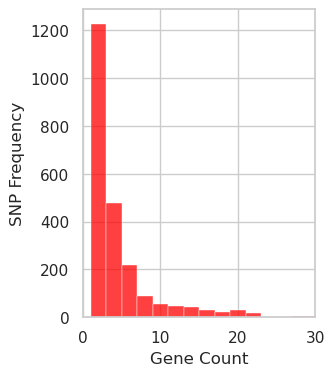

In [ ]:
# getting the data
genes_per_snp = t1d_uniq_sgls.groupby('snp_pos').geneid.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(3,4))
sns.set_theme(style="whitegrid")
sns.histplot(genes_per_snp['geneid'], color='red', binwidth=2, ax=ax)

ax.set_xlim(0, 30)
ax.set_xlabel('Gene Count')
ax.set_ylabel('SNP Frequency')

outfn = os.path.join(outdir, 't1d_sgls.genes_per_snp.mega-merged-only.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

In [ ]:
genes_per_snp.head()

,snp_pos,geneid
0,6:28080846,103
1,6:26021644,89
2,6:26157851,83
3,6:26157534,83
4,6:27806126,80


#### Perform Mann-Whitney Test Between GWAS Catalog & SGL Distributions

In [ ]:
# preprocess the GWAS data first
pd.set_option('display.max_columns', None)

# loading GWAS Catalog data
gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')

# extract genome-wide significance values
gc_data.loc[gc_data.loc[:, 'P-VALUE'] < 5*10**(-8)]

# dropping duplicate values
gc_data = gc_data.loc[gc_data.duplicated(['CHR_ID', 'CHR_POS'], keep='first')]

# drop 
gc_data = gc_data.loc[~gc_data['CHR_POS'].isna()]

# getting just the bed information
gc_data = gc_data.iloc[:, [11,12]]

# remove those that cannot be converted
def can_convert_to_int(x):
    try:
        int(x)
        return(True)
    except:
        return(False)
gc_data = gc_data.loc[gc_data['CHR_POS'].apply(can_convert_to_int)]

# convert to int
gc_data.loc[:, 'CHR_POS'] = gc_data['CHR_POS'].astype(int)


# rename and reorder
gc_data.rename(columns={'CHR_ID': 'chrom', 'CHR_POS': 'end'}, inplace=True)
gc_data['start'] = gc_data['end'] - 1
gc_data = gc_data.iloc[:, [0,2,1]]

# add chr
gc_data['chrom'] = 'chr' + gc_data['chrom']

# add 1mb to start and end
# gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 1000000))
# gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 1000000
gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 100000))
gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 100000

# sort
gc_data.sort_values(['chrom', 'start'], inplace=True)

/mnt/BioHome/jreyna/tmp/ipykernel_2757699/4155706276.py:5: DtypeWarning: Columns (12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')


##### Analyze the distribution of gene counts

In [ ]:
# intersect the SNPs with genes
gc_pbt = pbt.BedTool.from_dataframe(gc_data)
gencode_prots = gencode_df.loc[gencode_df['genetype'] == 'protein_coding']
gene_pbt = pbt.BedTool.from_dataframe(gencode_prots.iloc[:, [0,1,2,5]])

# map the genes to SNPs
gc_with_genes = gc_pbt.map(gene_pbt, c='4', o='count_distinct')
gc_with_genes_df = gc_with_genes.to_dataframe(header=None, disable_auto_names=True)
gc_with_genes_df = gc_with_genes_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_genes_df = gc_with_genes_df.loc[gc_with_genes_df.iloc[:, 3] != '.']
gc_with_genes_df.iloc[:, 3] = gc_with_genes_df.iloc[:, 3].astype(int)

<Axes: ylabel='Frequency'>

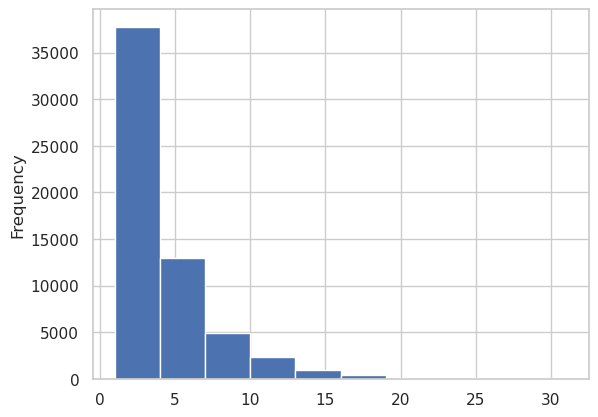

In [ ]:
gc_with_genes_df.iloc[:, 3].plot(kind='hist')

In [ ]:
def calculate_mannwhitenyu(dataA, dataB):

    # Step 1: Calculate medians
    median_A = np.median(data_A)
    median_B = np.median(data_B)

    # Step 2: Perform the Mann-Whitney U test
    # The test checks if the distribution of one sample is shifted relative to another
    statistic, p_value = mannwhitneyu(data_B, data_A, alternative='less')
    
    # return tuple result
    mw_ntuple = namedtuple('mw', ['median_A', 'median_B', 'statistic', 'p_value'])
    mw_result = mw_ntuple(median_A, median_B, statistic, p_value)
    return(mw_result)
    
    
def summarize_mannwhitenyu(result):

    # Print the results
    print(f"Median of A: {result.median_A}")
    print(f"Median of B: {result.median_B}")

    print(f"Mann-Whitney U statistic: {result.statistic}")
    print(f"P-value: {result.p_value}")

    # Interpretation
    alpha = 0.05  # Significance level
    if result.p_value < alpha:
        print("Reject the null hypothesis: The median of B is significantly smaller than the median of A.")
    else:
        print("Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.")
        
# Sample data (replace with your actual data)
data_A = np.array(gc_with_genes_df.iloc[:, 3].astype(int))  # Replace with your data for list A
data_B = np.array(genes_per_snp.geneid.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhiteyu(mw_genes)

Median of A: 3.0
Median of B: 2.0
Mann-Whitney U statistic: 70455782.5
P-value: 0.6914211857409889
Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.


In [ ]:
gc_with_genes_df

,0,1,2,3
0,chr1,860325,1060326,8
2,chr1,879471,1079472,9
3,chr1,899841,1099842,10
5,chr1,913489,1113490,10
7,chr1,923524,1123525,10
...,...,...,...,...
252858,chrX,155095892,155295893,5
252859,chrX,155233587,155433588,5
252860,chrX,155575418,155775419,2
252865,chrX,155657484,155857485,2


##### Analyze the distribution of SNP counts

In [ ]:
# making gc data with an id for mapping
gc_extra_data = gc_data.copy()
gc_extra_data['id'] = gc_extra_data['chrom'] + ':'  + gc_extra_data['start'].astype(str) + '-' + gc_extra_data['end'].astype(str)
gc_extra_pbt = pbt.BedTool.from_dataframe(gc_extra_data)

# map the genes to SNPs
gc_with_snps = gene_pbt.map(gc_extra_pbt, c='4', o='count_distinct')
gc_with_snps_df = gc_with_snps.to_dataframe(header=None, disable_auto_names=True)
gc_with_snps_df = gc_with_snps_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_snps_df = gc_with_snps_df.loc[gc_with_snps_df.iloc[:, 4] != '.']
gc_with_snps_df.iloc[:, 4] = gc_with_snps_df.iloc[:, 4].astype(int)


In [ ]:
gc_with_snps_df

,0,1,2,3,4
3,chr1,923927,944581,ENSG00000187634,6
4,chr1,944202,959309,ENSG00000188976,8
5,chr1,960583,965719,ENSG00000187961,8
6,chr1,966496,975865,ENSG00000187583,8
7,chr1,975203,982093,ENSG00000187642,8
...,...,...,...,...,...
19913,chrX,155380786,155381134,ENSG00000277858,1
19914,chrX,155382114,155383230,ENSG00000274791,1
19917,chrX,155489010,155669944,ENSG00000185973,2
19918,chrX,155767811,155782459,ENSG00000168939,2


In [ ]:
# Sample data (replace with your actual data)
data_A = np.array(gc_with_snps_df.iloc[:, 4].astype(int))  # Replace with your data for list A
data_B = np.array(snps_per_gene.snp_pos.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhiteyu(mw_genes)

Median of A: 7.0
Median of B: 3.0
Mann-Whitney U statistic: 8457274.0
P-value: 1.0780393465600809e-67
Reject the null hypothesis: The median of B is significantly smaller than the median of A.


### Compare to the Consensus Gene List

In [ ]:
def print_genelist(genelist):
    print('\n'.join(list(genelist)))

#### Save a list of unique genes for T1D

In [ ]:
# get the uniq T1D SGL genes
uniq_genes = t1d_df.genename.unique()
print('The unique number of genes is: {}'.format(len(uniq_genes)))

The unique number of genes is: 1310


In [ ]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(uniq_genes))
    fw.write(s)

#### Load the consensus T1D gene list

In [ ]:
t1d_consensus_list_fn = '<path-to-consensus-gene-list>' # example consensus_gene_list.txt
t1d_consensus_genes = pd.read_table(t1d_consensus_list_fn, header=None, names=['genename'])
print('The number of consensus genes is: {}'.format(t1d_consensus_genes.shape[0]))

The number of consensus genes is: 497


#### Overlap the SGL genes with the consensus genes 

In [ ]:
t1d_plus_consensus_df = t1d_df.loc[t1d_df.genename.isin(t1d_consensus_genes.iloc[:, 0].tolist())]

In [ ]:
shared_t1d_plus_consensus_genes = sorted(t1d_plus_consensus_df.genename.unique().tolist())
print('The unique number of genes is: {}'.format(len(shared_t1d_plus_consensus_genes)))

The unique number of genes is: 86


In [ ]:
all_t1d_genes = set(t1d_df.genename.tolist())

In [ ]:
only_t1d_genes = all_t1d_genes.difference(shared_t1d_plus_consensus_genes)

In [ ]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'left_venn_only.uniq_genes.t1d.mega-merged-only.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(only_t1d_genes))
    fw.write(s)

## Investigating Shared Genes

In [ ]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get shared genes for T1D
shared_gene_df = base_genes_df.loc[base_genes_df.genename.isin(shared_t1d_plus_consensus_genes)]

# set associated sgls
shared_gene_sgls = t1d_df.loc[all_df.geneid.isin(shared_gene_df.geneid.tolist())]

# testing the removal of hist proteins
shared_gene_sgls = shared_gene_sgls.loc[~shared_gene_sgls.genename.str.contains('HIST')]

# add distance 
shared_gene_sgls.loc[:, 'distance'] = shared_gene_sgls.loc[:, 'startB_loop'] - shared_gene_sgls.loc[:, 'startA_loop']

In [ ]:
shared_gene_sgls

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval,chrom,start_snp,end_snp,rsid,maf,ea,nea,beta,se,p,zscore,paintor,caviarbf,finemap,meta_id,block_id,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance
2,1,113760000,113765000,1,113810000,113815000,7.828671,1,113761185,113761186,rs6679677,0.0915,A,C,0.675492,0.032644,4.031301e-95,20.692685,0.137805,0.136825,0.136694,CA266,70,7.0,CA266,AnchorA,1,113812475,113812476,RSBN1,ENSG00000081019,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113761186,50000
12,10,6050000,6055000,10,6085000,6090000,11.581568,10,6054703,6054704,rs12722496,0.0785,G,A,-0.465852,0.039521,4.531013e-32,-11.787441,0.125196,0.121896,0.124940,CA266,1017,7.0,CA266,AnchorA,10,6089033,6089034,RBM17,ENSG00000134453,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,10:6054704,35000
13,10,6050000,6055000,10,6085000,6090000,11.581568,10,6052733,6052734,rs61839660,0.0696,T,C,-0.500710,0.041920,6.950323e-33,-11.944336,0.758506,0.767591,0.759243,CA266,1017,7.0,CA266,AnchorA,10,6089033,6089034,RBM17,ENSG00000134453,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,10:6052734,35000
30,12,55995000,56000000,12,56040000,56045000,22.665118,12,56041627,56041628,rs705704,0.3280,A,G,0.212932,0.022855,1.200347e-20,9.316683,0.141451,0.141887,0.141540,CA266,1214,7.0,CA266,AnchorB,12,55997179,55997180,SUOX,ENSG00000139531,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041628,45000
31,12,55995000,56000000,12,56040000,56045000,22.665118,12,56041719,56041720,rs705705,0.3280,C,G,0.213012,0.022829,1.051866e-20,9.330687,0.160502,0.161498,0.160699,CA266,1214,7.0,CA266,AnchorB,12,55997179,55997180,SUOX,ENSG00000139531,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041720,45000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60430,5,35830000,35835000,5,35850000,35855000,22.439913,5,35833520,35833521,rs7733008,0.2714,A,G,0.104000,0.021000,7.331091e-07,4.952381,0.013596,0.013226,0.013553,CA265,545,7.0,CA265,AnchorA,5,35852694,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35833521,20000
60431,5,35850000,35855000,5,35920000,35925000,13.997801,5,35921967,35921968,rs11950831,0.2674,G,A,0.107957,0.020992,2.705914e-07,5.142857,0.034471,0.034397,0.034471,CA265,545,7.0,CA265,AnchorB,5,35852694,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35921968,70000
60432,5,35850000,35855000,5,35920000,35925000,13.997801,5,35924645,35924646,rs6871116,0.2674,C,G,0.105980,0.020996,4.473500e-07,5.047619,0.021554,0.021234,0.021520,CA265,545,7.0,CA265,AnchorB,5,35852694,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35924646,70000
60451,6,90170000,90175000,6,90295000,90300000,5.432919,6,90170673,90170674,rs10944479,0.1869,A,G,0.168983,0.022998,2.014564e-13,7.347826,0.239499,0.235931,0.239328,CA265,692,7.0,CA265,AnchorA,6,90296907,90296908,BACH2,ENSG00000112182,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,6:90170674,125000


In [ ]:
# calculating genes which are present in SGLs across more than 3 samples
shared_gene_freqs = shared_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
shared_genes_high_freq = shared_gene_freqs[shared_gene_freqs > 3]
shared_genes_high_freq_list = shared_genes_high_freq.index.tolist()

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = []
candidates = shared_gene_sgls.loc[shared_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(shared_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

# display(candidates.iloc[:, 14:])
# #pd.options.display.max_rows = 200


In [ ]:
candidates.genename.unique()

array(['RAD51B', 'SMARCE1', 'IKZF3', 'CCR7', 'ATXN2L', 'PSMB2', 'SBK1'],
      dtype=object)

## Investigate Novel Genes

In [ ]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get novel genes for T1D
novel_gene_df = base_genes_df.loc[base_genes_df.genename.isin(only_t1d_genes)]

# set associated sgls
novel_gene_sgls = t1d_df.loc[all_df.geneid.isin(novel_gene_df.geneid.tolist())]

# testing the removal of hist proteins
novel_gene_sgls = novel_gene_sgls.loc[~novel_gene_sgls.genename.str.contains('HIST')]

# add distance 
novel_gene_sgls.loc[:, 'distance'] = novel_gene_sgls.loc[:, 'startB_loop'] - novel_gene_sgls.loc[:, 'startA_loop']

In [ ]:
#print(','.join(list(novel_gene_sgls.geneid.unique())))

In [ ]:
# counting snp-gene pairs 
novel_gene_sgls.loc[:, 'sgname'] = novel_gene_sgls.loc[:, 'genename'] + ' & ' + novel_gene_sgls.loc[:, 'snp_pos']
sgpair_counts = novel_gene_sgls.sgname.value_counts().to_frame()

I'm interested in the frequency of each SNP + gene pair. Hopefully there is a pair with lots of samples. 

In [ ]:
sgl_freqs = sgpair_counts.sort_index()['count'].unique()
sgl_freqs

array([ 2,  1,  4,  5,  6,  3,  8, 12, 15, 25, 20, 10, 16, 24,  9, 18,  7,
       36])

In [ ]:
sgpair_counts.head(10)


,count
sgname,
SGF29 & 16:28494339,36
AC138894.1 & 16:28525152,25
APOBR & 16:28528527,25
APOBR & 16:28525152,25
AC138894.1 & 16:28528527,25
AC138894.1 & 16:28526650,25
APOBR & 16:28520032,25
AC138894.1 & 16:28520032,25
APOBR & 16:28521750,25


In [ ]:
# calculating genes which are present in SGLs across more than 3 samples
novel_gene_freqs = novel_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
novel_genes_high_freq = novel_gene_freqs[novel_gene_freqs > 3]
novel_genes_high_freq_list = novel_genes_high_freq.index.tolist()

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = ['CD63', 'AC009779.2', 'AC073896.2', 'AC145285.3', 'SETD9', 'PUM3', 'AC022506.1', 'DDIT3', 'MBD6', 'PKNOX1', 'GPBP1']
check_genes += ['SLC30A1', 'ZBTB37', 'EIF1', 'CENPL', 'DARS2', 'ZFYVE26', 'KMT2E', 'NIPBL', 'BRIX1', 'RAD1', 'LONRF1']
check_genes += ['RAPGEF6', 'ITGB1', 'FAM210A', 'RNMT', 'DTL', 'INTS7', 'SIMM12', 'EPC1', 'SMIM12', 'NUDT6']
check_genes += ['RFX3', 'SPATA5', 'DUSP28', 'HSPA4', 'ZIC2', 'ANKMY1', 'RNPEPL1', 'ZSCAN22', 'FKBP1B']
check_genes += ['WDCP', 'SFPQ', 'CYP20A1', 'DOCK9', 'NCK1', 'FANCI', 'RRP1', 'STK40', 'AFG3L2']
check_genes += ['STAG1', 'NEK7', 'UBE2G2', 'RO60', 'DNAJC27', 'TNFSF4', 'ABHD2', 'IFT27', 'GDF9', 'UQCRQ']
check_genes += ['PRKAR1A', 'WIPI1', 'NCF4', 'TRAPPC10', 'PTRHD1', 'HAPLN3', 'HEXIM2', 'KIF14', 'UBAC2']
check_genes += ['GDF11', 'STARD3', 'SECISBP2', 'RARA', 'CCR1', 'CCR2', 'ORMDL2', 'SENP3', 'SENP3-EIF4A1']
candidates = novel_gene_sgls.loc[novel_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(novel_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

#display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


In [ ]:
# for x in candidates.genename.unique():
#     print(x)

Unfortunately there are not. Initially I was trying to find an example where a SGL is found across many samples but this is just not found in the data. So I started to think, what else can I find or what other point can I make? For now, the point that I will try making is that we found a good SNP (or gene) which is found across many samples. 

I'll start with a good SNP, if I find one. 

In [ ]:
# snp_counts = novel_gene_sgls.drop_duplicates(subset=['sample', 'snp_pos']) # want unique sample + snps
# snp_counts = snp_counts.groupby(by=['snp_pos']).count()['chrA_loop'] # counting the unique number of snps per sample 
# snp_counts = snp_counts.reset_index().rename(columns={'chrA_loop': 'count'}).sort_values(['count'], ascending=[True, False]) # cleaning + sorting
# snp_counts = snp_counts.pivot(index='snp_pos', columns='sample_grp', values='count', ) # pivoting for side-by-side analysis of grps
# snp_counts = snp_counts.fillna(0) # remove NaN's
# snp_counts = snp_counts.astype(int) # convert to ints
# snp_counts.loc[:, 'sum'] = snp_counts.iloc[:, 0:6].sum(axis=1) # add row sum
# snp_counts.loc[:, 'max'] = snp_counts.iloc[:, 0:6].max(axis=1) # add row max

# # add the mb location
# def get_mb(x):
#     spl = x.split(':')
#     res = spl[0] + ':' + spl[1][0:2]
#     return(res)
# snp_counts['chr_mb'] = [get_mb(x)for x in snp_counts.index.values]

# # filter based on the max
# snp_counts_flt = snp_counts.loc[snp_counts['max'] > 2].sort_values(['chr_mb', 'max'], ascending=[True, False])

# snp_counts_flt = snp_counts_flt.reset_index().set_index(['chr_mb', 'snp_pos']) # creating multi-index with chr_mb

In [ ]:

# # highlight based on the max
# def highlight_max(data, color='yellow'):
#     '''
#     highlight the maximum in a Series or DataFrame
#     '''
#     attr = 'background-color: {}'.format(color)
#     if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
#         is_gte_thresh = data > 3
#         return [attr if v else '' for v in is_gte_thresh]
#     else:  # from .apply(axis=None)
#         is_gte_thresh = data > 3
#         return pd.DataFrame(np.where(is_max, attr, ''),
#                             index=data.index, columns=data.columns)

# snp_counts_flt.style.apply(highlight_max, subset=['max'])

In [ ]:
# novel_gene_sgls.loc[(novel_gene_sgls.snp_pos.str.contains('^11:64'))]['genename']

#### Deeper dive into specific cases

In [ ]:
novel_geneA = 'ZNF487'
novel_gene_df = t1d_df.loc[t1d_df.genename == novel_geneA]
novel_gene_df

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval,chrom,start_snp,end_snp,rsid,maf,ea,nea,beta,se,p,zscore,paintor,caviarbf,finemap,meta_id,block_id,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos
15764,10,42960000,42965000,10,43435000,43440000,4.844114,10,42963500,42963501,rs556452586,0.0069,A,G,0.5713,0.1375,0.000033,4.154909,0.128379,0.028581,0.138647,GD09519,1039,7.0,GD09519,AnchorA,10,43436840,43436841,ZNF487,ENSG00000243660,+,Monocyte_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,10:42963501


In [ ]:
t = novel_gene_sgls.drop_duplicates(['geneid', 'sample'])

In [ ]:
t.value_counts(subset=['genename', 'geneid']).head(20)

genename    geneid         
STK40       ENSG00000196182    6
STARD3      ENSG00000131748    6
BTN2A2      ENSG00000124508    6
FMNL1       ENSG00000184922    6
SFPQ        ENSG00000116560    6
SGF29       ENSG00000176476    6
TRAPPC9     ENSG00000167632    6
AL031777.3  ENSG00000282988    6
APOBR       ENSG00000184730    6
HSPA4       ENSG00000170606    6
UBAC2       ENSG00000134882    6
ZSCAN31     ENSG00000235109    6
ZNF165      ENSG00000197279    6
CHRAC1      ENSG00000104472    6
AC116366.3  ENSG00000283782    6
CFAP410     ENSG00000160226    6
AC138894.1  ENSG00000261832    6
CEP76       ENSG00000101624    6
PDXK        ENSG00000160209    6
MSL2        ENSG00000174579    6
Name: count, dtype: int64